In [37]:
import matplotlib.pyplot as plt
import numpy as np

from diffractio.scalar_masks_X import Scalar_mask_X
%matplotlib ipympl


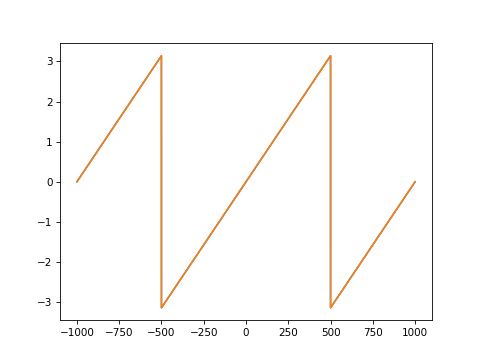

In [38]:
wavelength = 1

width = 2000
d = 1000
T = width / d
x = np.linspace(-1000,1000,10000)
z = np.linspace(2 * 1e3, 2 * 1e3, 128)

t_blazed_x = Scalar_mask_X(x, wavelength)
t_blazed_x.blazed_grating(x0=0, period=1000, phase_max=2 * np.pi)
phase_grating = np.exp(1j * (x * T * 2 * np.pi) / width)

phase_grating_derivative = (T * 2 * np.pi) / width

plt.figure()
plt.plot(x, np.angle(t_blazed_x.u))
plt.plot(x, np.angle(phase_grating))

In [39]:
def calculate_mdx_mdy(x1, y1, z1, u1, v1, z2):
    
    # Calculate derivatives 
    d_x1 = d_y1 = z1 / 1000
    
    # Direction vectors of derivative ray
    d_vx_pp1 = u1 - (x1 + d_x1)
    d_vy_pp1 = v1 - (y1 + d_y1)
    vz_pp1 = 0.0 - z1
    d_v_mag = np.sqrt(d_vx_pp1**2 + d_vy_pp1**2 + vz_pp1**2)
    
    # And direction cosines
    d_M1_p = d_vy_pp1 / d_v_mag 
    d_L1_p = d_vx_pp1 / d_v_mag

    d_x2 = z2 * d_L1_p
    d_y2 = z2 * d_M1_p
    
    # To obtain derivative in magnification - which I don't know at all if it is correct. 
    mdx = d_x2 / (x1 + d_x1)
    mdy = d_y2 / (y1 + d_y1)
    
    return mdx, mdy

def calculate_direction_cosines(x0, y0, z0, x1, y1, z1):
    # Calculate the principal ray vector from ray coordinate on object to centre of lens
    vx = x1 - x0
    vy = y1 - y0
    vz = z1 - z0
    v_mag = np.sqrt(vx**2 + vy**2 + vz**2)
    
    # And it's direction cosines
    M = vy / v_mag 
    L = vx / v_mag
    N = vz / v_mag
    
    return L, M, N
    
    
def propagate(x, y, z, L, M, N, d):
    x1 = x + (L / N) * d
    y1 = y + (M / N) * d
    z1 = z + N * d
    
    return x1, y1, z1

def diffraction_grating(x, y, z, L, M, N, opl, wl, Order = 1, T = 1, width = 10):
    random_order = np.random.choice([-1, 1], len(x))

    L1 = L
    M1 = M + (random_order * wl * T) / width
    N1 = np.sqrt(1 - L1 ** 2 - M1 ** 2)
    opl1 = opl + (random_order * wl * T * y) / width 
    
    return x, y, z, L1, M1, N1, opl1
    


In [40]:
def fourier_lens(x1, y1, z1, L1, M1, N1, z2, m_p, opl_in):
    
    # Obtain the location where the ray hits the first principal plane
    u1 = - (L1 / N1) * z1 + x1
    v1 = - (M1 / N1) * z1 + y1
    
    # If magnification is less than or equal to 1.0 - run this block
    if np.abs(m_p) <= 1.0:
        if np.abs(m_p) <= 1e-10:
            z1_old = z1
            z1 = -1e10
            m_p = z2 / z1
            
            principal_plane_x = u1
            principal_plane_y = v1
            L1_p, M1_p, N1_p = L1, M1, N1
            
            mdx, mdy = calculate_mdx_mdy(x1, y1, z1_old, principal_plane_x, principal_plane_y, z2)
        else:
            principal_plane_x = 0.0
            principal_plane_y = 0.0
            L1_p, M1_p, N1_p = calculate_direction_cosines(x1, y1, z1, principal_plane_x, principal_plane_y, 0.0)
            
            mdx, mdy = calculate_mdx_mdy(x1, y1, z1, principal_plane_x, principal_plane_y, z2)
        
        # Obtain coordinates in image plane relative to principal ray location
        x2 = z2 * L1_p
        y2 = z2 * M1_p
    
        rp = np.sqrt(x2 ** 2 + y2 **2 + z2 ** 2)
        
        # Obtain direction cosines of principal ray from second principal plane to image point
        L2_p = (x2 - principal_plane_x)  / rp
        M2_p = (y2 - principal_plane_y) / rp
        N2_p = np.sqrt(1 - L2_p ** 2 - M2_p ** 2)
        
    # For the case when m is greater than 1.0
    elif np.abs(m_p) > 1.0:
        if np.abs(m_p) >= 1e10:
            z2_old = z2
            z2 = 1e10
            m_p = z2 / z1
            principal_plane_x = u1
            principal_plane_y = v1
            mdx, mdy = calculate_mdx_mdy(x1, y1, z1, principal_plane_x, principal_plane_y, z2)
            L1_p, M1_p, N1_p = calculate_direction_cosines(x1, y1, z1, 0.0, 0.0, 0.0)
        else:
            z2_old = z2
            principal_plane_x = 0.0
            principal_plane_y = 0.0
            L1_p, M1_p, N1_p = calculate_direction_cosines(x1, y1, z1, principal_plane_x, principal_plane_y, 0.0)
            mdx, mdy = calculate_mdx_mdy(x1, y1, z1, principal_plane_x, principal_plane_y, z2)
            
        L2_p = x1 / z1
        M2_p = y1 / z1
        N2_p = np.sqrt(1 - L2_p ** 2 - M2_p ** 2)
        
        z2 = z2_old
        x2 = (L2_p / N2_p) * z2 + principal_plane_x
        y2 = (M2_p / N2_p) * z2 + principal_plane_y

    Cx = (mdx * L2_p) - L1_p
    Cy = (mdy * M2_p) - M1_p

    L2 = (L1 + Cx) / mdx
    M2 = (M1 + Cy) / mdy
    N2 = (1 - (L2 ** 2) - (M2 ** 2)) ** (1/2)

    #Analytic direction cosines:
    u2 = - (L2 / N2) * z2 + x2
    v2 = - (M2 / N2) * z2 + y2
    
    opl1 = np.sqrt((u1 - x1) ** 2 + (v1 - y1) **2 + (z1 ** 2)) + np.sqrt((x2 - u2) ** 2 + (y2 - v2) **2 + (z2 ** 2)) 
    opl0 = np.sqrt((u1 - principal_plane_x) ** 2 + (v1 - principal_plane_y) **2 + (z1 ** 2)) + np.sqrt((x2 - principal_plane_x) ** 2 + (y2 - principal_plane_y) **2 + (z2 ** 2)) 
    
    opl_ray = opl_in + (opl0 - opl1)
    return x2, y2, u1, v1, u2, v2, L2, M2, N2, opl_ray
    

In [41]:
def perfect_lens(x1, y1, z1, L1, M1, N1, z2, m_p, opl_in):
    
    # Obtain the location where the ray hits the first principal plane
    u1 = - (L1 / N1) * z1 + x1
    v1 = - (M1 / N1) * z1 + y1
    
    mdx = mdy = m_p
    
    # If magnification is less than or equal to 1.0 - run this block
    if np.abs(m_p) <= 1.0:
        if np.abs(m_p) <= 1e-10:
            z1 = -1e10
            m_p = z2 / z1
            
            principal_plane_x = u1
            principal_plane_y = v1
            L1_p, M1_p, N1_p = L1, M1, N1
        else:
            principal_plane_x = 0.0
            principal_plane_y = 0.0
            L1_p, M1_p, N1_p = calculate_direction_cosines(x1, y1, z1, principal_plane_x, principal_plane_y, 0.0)
            
        # Obtain coordinates in image plane relative to principal ray location
        x2 = z2 * L1_p / N1_p
        y2 = z2 * M1_p / N1_p
    
        rp = np.sqrt(x2 ** 2 + y2 **2 + z2 ** 2)
        
        # Obtain direction cosines of principal ray from second principal plane to image point
        L2_p = (x2 - principal_plane_x) / rp
        M2_p = (y2 - principal_plane_y) / rp
        N2_p = np.sqrt(1 - L2_p ** 2 - M2_p ** 2)
        
    # For the case when m is greater than 1.0
    elif np.abs(m_p) > 1.0:
        if np.abs(m_p) >= 1e10:
            z2_old = z2
            z2 = 1e10
            m_p = z2 / z1
            principal_plane_x = u1
            principal_plane_y = v1
            mdx, mdy = calculate_mdx_mdy(x1, y1, z1, principal_plane_x, principal_plane_y, z2)
            L1_p, M1_p, N1_p = calculate_direction_cosines(x1, y1, z1, 0.0, 0.0, 0.0)
        else:
            z2_old = z2
            principal_plane_x = 0.0
            principal_plane_y = 0.0
            L1_p, M1_p, N1_p = calculate_direction_cosines(x1, y1, z1, principal_plane_x, principal_plane_y, 0.0)
            
        a = x1 / z1
        b = y1 / z1

        z2 = z2_old
        N2_p = np.sqrt(1 + a ** 2 + b ** 2)
        L2_p = a * N2_p
        M2_p = b * N2_p
        x2 = (L2_p / N2_p) * z2 + principal_plane_x
        y2 = (M2_p / N2_p) * z2 + principal_plane_y
        
    Cx = (mdx * L2_p) - L1_p
    Cy = (mdy * M2_p) - M1_p

    L2 = (L1 + Cx) / mdx
    M2 = (M1 + Cy) / mdy
    N2 = (1 - (L2 ** 2) - (M2 ** 2)) ** (1/2)

    #Analytic direction cosines:
    u2 = - (L2 / N2) * z2 + x2
    v2 = - (M2 / N2) * z2 + y2
    
    opl1 = np.sqrt((u1 - x1) ** 2 + (v1 - y1) **2 + (z1 ** 2)) + np.sqrt((x2 - u2) ** 2 + (y2 - v1) **2 + (z2 ** 2)) 
    opl0 = np.sqrt((x1 - principal_plane_x) ** 2 + (y1 - principal_plane_y) **2 + (z1 ** 2)) + np.sqrt((x2 - principal_plane_x) ** 2 + (y2 - principal_plane_y) **2 + (z2 ** 2)) 
    
    opl_ray = opl_in + (opl0 - opl1)
    return x2, y2, u1, v1, u2, v2, L2, M2, N2, opl_ray
    

Perfect Lens: Infinite Front Conjugate Case

In [42]:
lens_z = 0.0
thickness = 0.0
pp_1 = lens_z - thickness / 2.0
pp_2 = lens_z + thickness / 2.0

m_p = -4
f = 8

if np.abs(m_p) < 1e-10:
    z1 = f * (-1)  
    z2 = f * (1)
elif np.abs(m_p) > 1e10:
    z1 = f * (-1)  
    z2 = f * (1)
else:
    z1 = f * ((1 / m_p)  -1)
    z2 = f * (1 - m_p)

N = 10

# Define x and y coordinates of rat starting positions
x1 = np.linspace(-0.0, 0.0, N)
y1 = np.linspace(0, 0, N)
z1 = np.linspace(z1, z1, N)

angles = np.linspace(0, 1, N)

L1 = np.zeros(N) # x direction cosine
M1 = np.sin(angles) # y direction cosine
N1 = np.sqrt(1 - L1 ** 2 - M1 ** 2) #z direction 

opl = np.linspace(0, 0, N)

[  0.          -0.07760451  -0.31586636  -0.73207742  -1.35852714
  -2.24897645  -3.49102848  -5.23021976  -7.71979577 -11.43311358]
[  0.          -0.0929821   -0.37672405  -0.86657347  -1.59162757
  -2.6012864   -3.97774756  -5.86027566  -8.49521796 -12.34871136]


(-12.5, 42.5, -1.8287038623274512, 16.40278110887647)

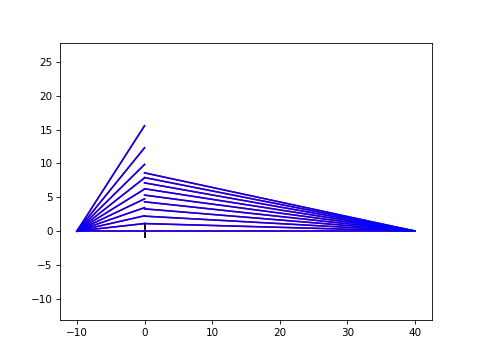

In [43]:
x2, y2, u1, v1, u2, v2, L2, M2, N2, opl = perfect_lens(x1, y1, z1, L1, M1, N1, z2, m_p, opl)

print(opl)
plt.figure()
plt.vlines(pp_1, -1, 1, linestyle = '--', color = 'k')
plt.vlines(pp_2,  -1, 1, linestyle = '--', color = 'k')

pp_1s = np.linspace(pp_1, pp_1, N)
pp_2s = np.linspace(pp_2, pp_2, N)
z1s = np.linspace(z1, z1, N)
z2s = np.linspace(z2, z2, N)
fs = np.linspace(f, f, N)

plt.plot([z1 + pp_1s, pp_1s], [y1, v1], '-r')
plt.plot([], [], '-r', label = 'Perfect Lens')

plt.plot([pp_2s, z2s + pp_2s], [v2, y2], '-r')
plt.axis('equal')

x2, y2, u1, v1, u2, v2, L2, M2, N2, opl  = fourier_lens(x1, y1, z1, L1, M1, N1, z2, m_p, opl)
print(opl)

pp_1s = np.linspace(pp_1, pp_1, N)
pp_2s = np.linspace(pp_2, pp_2, N)
z1s = np.linspace(z1, z1, N)
z2s = np.linspace(z2, z2, N)
fs = np.linspace(f, f, N)

plt.plot([z1 + pp_1s, pp_1s], [y1, v1], '-b')
plt.plot([], [], '-b', label = 'Fourier Lens')

plt.plot([pp_2s, z2s + pp_2s], [v2, y2], '-b')
plt.axis('equal')

Now for diffraction grating...

In [45]:
plane_wave_z = 0.0
diff_grating_z = 10
lens_z_1 = 20
lens_z_2 = 32
N = 10
wl = 1.0

f1 = 10
f2 = 2
m_p = 1e-11
zl_1_1 = -f1
zl_1_2 = f1

zl_2_1 = -f2
zl_2_2 = f2

rx, ry, rz = np.linspace(0, 0, N), np.random.uniform(-1, 1, N), np.linspace(plane_wave_z, plane_wave_z, N)
M0, L0, N0 = np.linspace(0, 0, N), np.linspace(0, 0, N), np.linspace(1, 1, N)

rx_diff_l, ry_diff_l, rz_diff_l = propagate(rx, ry, rz, L0, M0, N0, diff_grating_z - plane_wave_z)

opl0 = np.linspace(0, 0, N)
rx_diff_r, ry_diff_r, rz_diff_r, L1, M1, N1, opl1 = diffraction_grating(rx_diff_l, ry_diff_l, rz_diff_l, L0, M0, N0, opl0, wl)

rx_lens1_f, ry_lens1_f, rx_lens1_zl, ry_lens1_zl, rx_lens1_zr, ry_lens1_zr, L2, M2, N2, opl2 = fourier_lens(rx_diff_r, ry_diff_r, -f1, L1, M1, N1, f1, 1e-11, opl1)
rx_lens2_f, ry_lens2_f, rx_lens2_zl, ry_lens2_zl, rx_lens2_zr, ry_lens2_zr, L3, M3, N3, opl3 = fourier_lens(rx_lens1_f, ry_lens1_f, -f2, L2, M2, N2, f2, 1e11, opl2)



<Figure size 480x360 with 0 Axes>

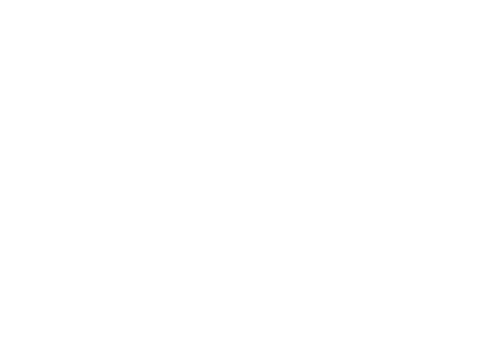

In [46]:
plt.figure()
# plt.vlines(plane_wave_z, -1, 1, color = 'k', linestyle = '-')
# plt.plot([rz, rz_diff_l], [ry, ry_diff_l], '-k')
# plt.vlines(diff_grating_z, -10, 10, color = 'k', linestyle = '-')
# plt.plot([lens_z_1 + zl_1_1, lens_z_1], [ry_diff_r, ry_lens1_zl], '-k')
# plt.plot([lens_z_1, lens_z_1 + zl_1_2], [ry_lens1_zl, ry_lens1_f], '-k')
# plt.vlines(lens_z_1, -10, 10, color = 'k', linestyle = '-')
# # x2, y2, u1, v1, u2, v2, L2, M2, N2  = fourier_lens(x1, y1, z1, L1, M1, N1, z2, m_p)

# plt.plot([lens_z_2 + zl_2_1, lens_z_2], [ry_lens1_f, ry_lens2_zl], '-k')
# plt.plot([lens_z_2, lens_z_2 + zl_2_2], [ry_lens2_zr, ry_lens2_f], '-k')
# plt.vlines(lens_z_2, -10, 10, color = 'k', linestyle = '-')